## AI Inference from a video file
This notebook is an example how to use DeGirum PySDK to do AI inference of a video stream from a video file. The annotated video is saved into new file with `_annotated` suffix.

This script works with the following inference options:

1. [DeGirum Cloud Platform](https://cs.degirum.com),
1. DeGirum-hosted AI server node shared via Peer-to-Peer VPN,
1. AI server node hosted by you in your local network,
1. AI server running on your local machine,
1. DeGirum ORCA accelerator directly installed on your local machine.

To try different options, you just need to change the `inference_option` in the code below.

### Specify where do you want to run your inferences and video file name here

In [11]:
inference_option = 1  # <<< change it according to your needs selecting from the list in the header comment
input_filename = "./images/Traffic.mp4" # video file to process

### The rest of the cells below should run without any modifications

In [9]:
import degirum as dg # import DeGirum PySDK
import mytools, cv2
from pathlib import Path

In [3]:
# connect to model zoo according to selected inference option
zoo = mytools.connect_model_zoo(inference_option)

Inference option = 'DeGirum Cloud Platform'


In [59]:
# load object detection model
# (change model name to "...n2x_cpu_1" to run it on CPU)
model = zoo.load_model("yolo_v5s_coco--512x512_quant_n2x_orca_1")

# set model parameters
model.image_backend = 'opencv' # select OpenCV backend: needed to have overlay image in OpenCV format
model.input_numpy_colorspace = 'BGR'
model.overlay_show_probabilities = True # show probabilities on overlay image
model._model_parameters.InputImgFmt = ['JPEG']
model.overlay_line_width = 1

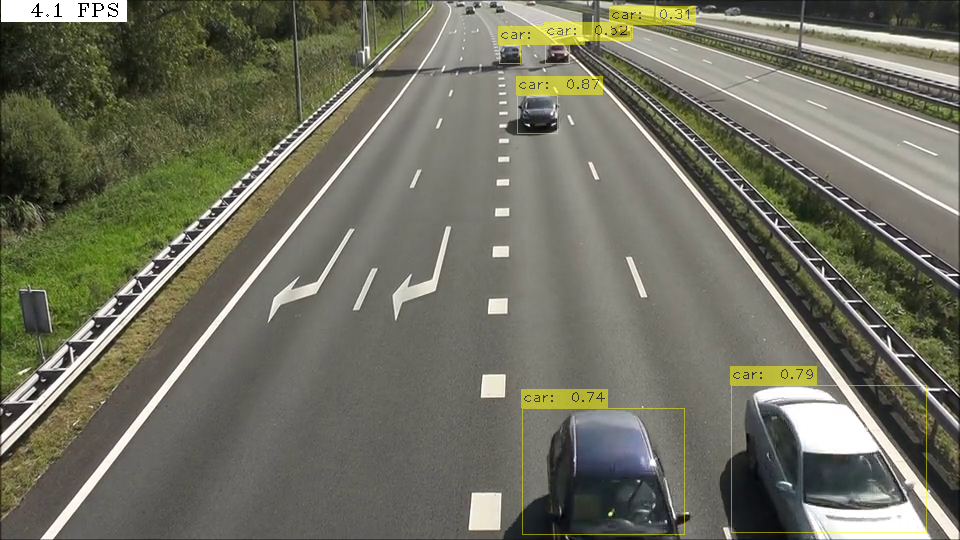

In [63]:
orig_path = Path(input_filename)
ann_path = orig_path.with_name(orig_path.stem + "_annotated" + orig_path.suffix)

stream = mytools.open_video_stream("./images/Traffic.mp4") # open video stream form file
writer = cv2.VideoWriter() # create stream writer

# AI prediction loop
# Press 'x' or 'q' to stop
with mytools.Display("AI Camera") as display:
    for res in model.predict_batch(mytools.video_source(stream, report_error=False)):
        img = res.image_overlay
        if not writer.isOpened():
            if not writer.open(str(ann_path), cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 30, (img.shape[1],img.shape[0])):
                raise Exception(f"Fail to open '{str(ann_path)}'")
        writer.write(res.image_overlay)
        display.show(res.image_overlay)
        
stream.release() # release camera stream
writer.release() 